### Example of expected power module usage

In [16]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(r'C:\Users\abbey\OneDrive\Documents\Projects\WindEnergy\wind-energy-analytics\scada_data_analysis')
from scipy.interpolate import interp1d
from utils.binning_function import binning_func
from modules.power_curve_preprocessing import PowerCurveFiltering as pcf

In [17]:
df = pd.read_csv('..\datasets\la-haute-borne-data-2017-2020.zip', sep=';')

In [18]:
pc_filter = pcf(turbine_label='Wind_turbine_name', windspeed_label='Ws_avg',
                power_label='P_avg', data=df, cut_in_speed=3, bin_interval=0.5,
                z_coeff=2.5, filter_cycle=5)

In [19]:
%%time
normal_df, _ = pc_filter.process()

CPU times: total: 6.08 s
Wall time: 6.07 s


### For each turbine, get statistics of the wind speed bin and active power

In [6]:
def binning_func(turbine_data, turbine_label='Wind_turbine_name', windspeed_label='Ws_avg',
                power_label='P_avg', data=df, cut_in_speed=3, bin_interval=0.5,
                z_coeff=2.5):
        """
        Bins wind speed into group of values using bin_interval
        
        turbine_data: pandas dataframe containing windspeed and power columns
        
        Returns: Median wind speed, average and standard deviation of produced power for each bin
        """
        turb_df = turbine_data.copy()
        max_windspeed = int(max(turb_df[windspeed_label]))
        
        windspeed_bins = pd.IntervalIndex.from_tuples([(round(bin_interval*a, 2),
                                                        round((bin_interval*a)+bin_interval, 2))\
                                                            for a in range(0, 2*max_windspeed+1)])
        
        turb_df.loc[:, 'windspeed_bin'] = pd.cut(turb_df[windspeed_label], bins=windspeed_bins)
        
        binned_turb_df = turb_df.groupby('windspeed_bin', as_index=False)[[windspeed_label,
                                                                           power_label]].agg({windspeed_label: 'median',
                                                                           power_label: ['mean', 'std']},
                                                                           as_index=False).dropna(subset=[(power_label,
                                                                           'mean')]).fillna({(power_label,
                                                                                              'std'): 0}).reset_index(drop=True)
        
        binned_turb_df.columns = ['windspeed_bin', 'windspeed_bin_median', 'pwr_bin_mean', 'pwr_bin_std']
        
        return binned_turb_df

In [7]:
def expected_power_run(dff, normal_dff, method='linear'):
    dff = dff.copy()
    normal_dff = normal_dff.copy()
    dff['expected_power'] = 0
    
    turbine_names = dff['Wind_turbine_name'].unique()
    
    for turbine_name in turbine_names:
        turb_df = dff[dff.Wind_turbine_name == turbine_name]
        turb_df_index = turb_df.index
        
        normal_turb_df = normal_dff[normal_dff.Wind_turbine_name == turbine_name]
        binned_df = binning_func(normal_turb_df)
        
        f = interp1d(binned_df.windspeed_bin_median, binned_df.pwr_bin_mean, kind=method, fill_value="extrapolate")

        dff.loc[turb_df_index, 'expected_power'] = f(turb_df.Ws_avg)
        
    dff['expected_power'].clip(0, inplace=True)
    
    return dff

In [8]:
%%time
proc_df = expected_power_run(df, normal_df, 'cubic')

Wall time: 926 ms


In [9]:
proc_df.shape

(217588, 139)

In [10]:
df.shape

(217588, 138)

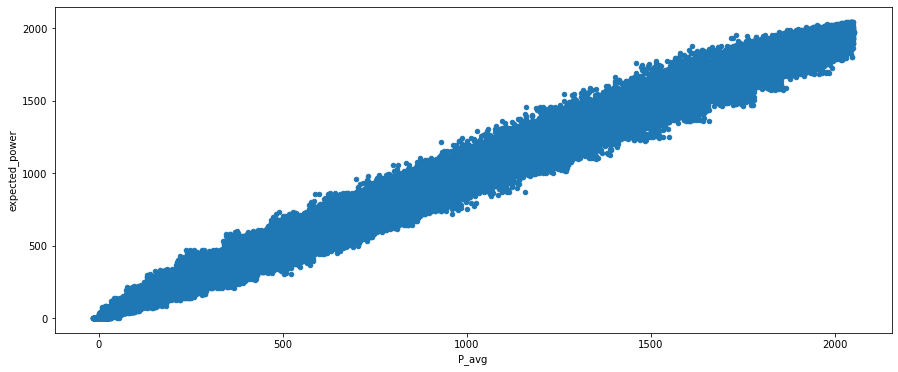

In [11]:
proc_df.loc[normal_df.index].plot('P_avg', 'expected_power', kind='scatter', figsize=(15,6));

In [12]:
y_exp = proc_df.loc[normal_df.index]['expected_power']
y_true = proc_df.loc[normal_df.index]['P_avg']

In [13]:
x = range(len(y_exp))

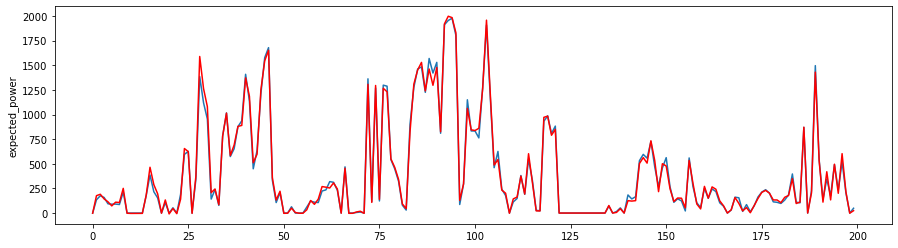

In [14]:
plt.figure(figsize=(15,4))
sns.lineplot(x=x[:200],y=y_exp[:200]);
sns.lineplot(x=x[:200],y=y_true[:200], color='red');

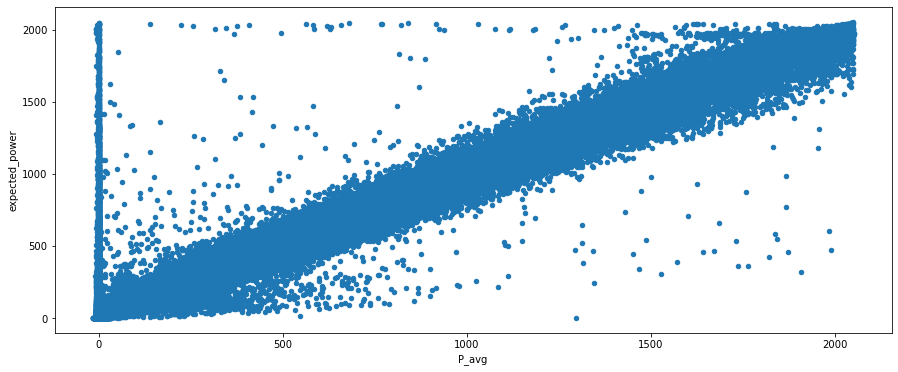

In [75]:
proc_df.plot('P_avg', 'expected_power',  kind='scatter', figsize=(15,6));

In [52]:
np.sum(proc_df.expected_power - proc_df.P_avg)/np.sum(proc_df.expected_power)*100

2.1256285987494716

In [53]:
np.mean(abs(proc_df.expected_power - proc_df.P_avg))

40.13112569128626